**Bike Network Data Analysis**

This notebook is used to perform basic analysis of both the bike network and wider underlying street network. It requires the prior notebook (00-bike-network-data-collection.ipynb) to have been run to collect the street networks from OpennStreetMap.

In [431]:
# libary imports
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
import os
import networkx as nx
import momepy
import pandas as pd
import numpy as np


# get working directory
working_directory =  os.getcwd()

In [364]:
# get street networks

bike_network = ox.io.load_graphml(working_directory + "\data\\bike_network.xml")

road_network =  ox.io.load_graphml(working_directory + "\data\\road_network.xml")

# get area boundary 

boundary = gpd.read_file(working_directory + "\data\\boundary.gpkg")

In [365]:
# convert graphs to gdfs

bike_network_edges = ox.utils_graph.graph_to_gdfs(bike_network, nodes=False)

road_network_edges = ox.utils_graph.graph_to_gdfs(road_network, nodes=False)

In [366]:
# create undirected graphs with bearings

bike_network_undirected = ox.add_edge_bearings(ox.utils_graph.get_undirected(bike_network))

road_network_undirected = ox.add_edge_bearings(ox.utils_graph.get_undirected(road_network))

In [367]:
# calculate lenghts of streets

bike_length = (bike_network_edges['length'].sum())* 0.0001 # convert to km

road_length = (road_network_edges['length'].sum())* 0.0001 # convert to km


# save to Dataframe

lengths_df = gpd.GeoDataFrame([road_length, bike_length])

row_names = {0:'Road',
            1:'Bike Paths'}

lengths_df = lengths_df.rename(index = row_names)


(array([0, 1]), [Text(0, 0, 'Road'), Text(1, 0, 'Bike Paths')])

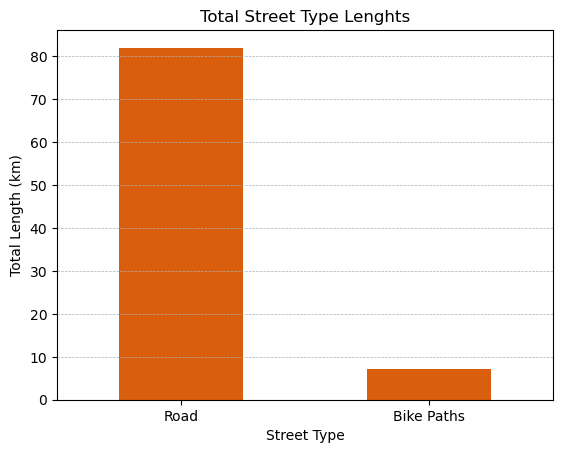

In [368]:
# plot street lenghts

colours = ['#d95f0e', '#fec44f']
ax = lengths_df.plot.bar(color=colours)
ax.set_xlabel("Street Type")
ax.set_ylabel("Total Length (km)")
ax.get_legend().remove()
plt.title("Total Street Type Lenghts")
plt.grid(True, axis='y', linestyle='--', linewidth=0.5)
plt.xticks(rotation=0)

In [369]:
# calculate the ratio of road compared to bike streets

def ratioFunction(input1, input2):
    num1 = input1
    num1 = float(num1) 
    num2 = input2
    num2 = float(num2) 
    ratio12 = float(num1/num2)
    print('The ratio of road network (', num1, 'km) to bike network (', num2,'km) is 1 :', str(ratio12) + '.')
    return(ratio12)

road_to_bike_ratio = ratioFunction(road_length, bike_length)

The ratio of road network ( 81.9897334 km) to bike network ( 7.090145200000001 km) is 1 : 11.563900468498161.


In [370]:
# calculate number of disconnected components

bike_components = nx.number_connected_components(bike_network_undirected)

In [371]:
# THIS MAY NEED CHANGING
# calculate the mean level of disconnect

mean_level_of_disconnect = bike_components/bike_length 

print(mean_level_of_disconnect)

12.12951181874244


In [372]:
# find the total number of intersections 

bike_intersections = bike_network.number_of_nodes()

road_intersections = road_network.number_of_nodes()

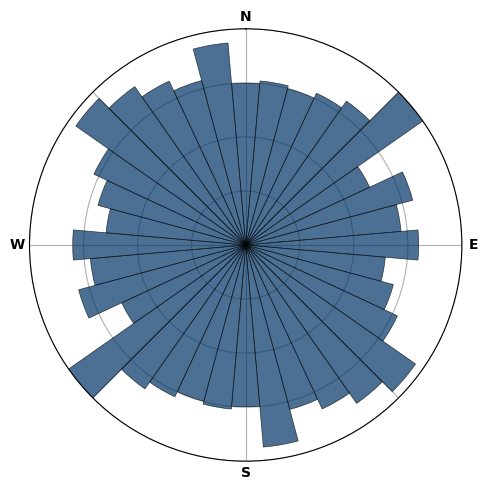

In [373]:
# measure bike network orientation

ox.bearing.plot_orientation(bike_network_undirected)

fig.suptitle("Bike network orientation")
fig.tight_layout()
fig.subplots_adjust(hspace=0.35)

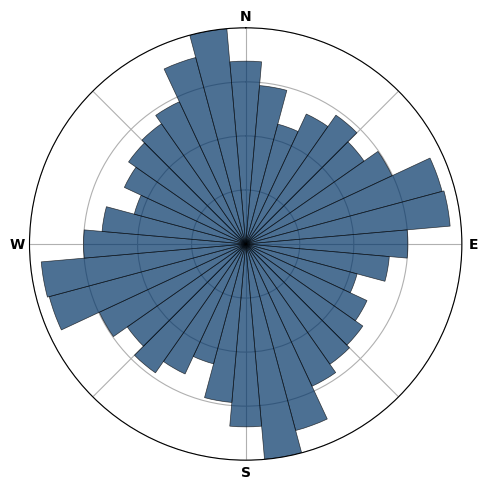

In [374]:
# measure road network orientation

ox.bearing.plot_orientation(road_network_undirected)

fig.suptitle("Road network orientation")
fig.tight_layout()
fig.subplots_adjust(hspace=0.35)

u            v            key
531116       1596025427   0       68.9
531134       1661058447   0        5.1
             257018325    0      286.0
             257018246    0      193.2
531135       257015026    0       25.6
                                 ...  
8984690431   8984690432   0       10.6
9034894712   9034894713   0      154.7
9176836743   9176836746   0      132.4
                          1      132.4
10583048185  10583048187  0       61.5
Name: bearing, Length: 4379, dtype: float64

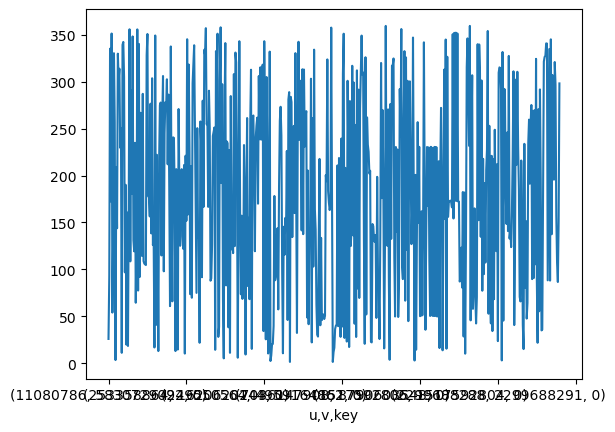

In [375]:
# want to compare these two plots somehow, find a level of differance between

# can turn u-graph to gdf to access bearing of every edge

bike_network_undirected_gdf = ox.utils_graph.graph_to_gdfs(bike_network_undirected, nodes=False)

road_network_undirected_gdf = ox.utils_graph.graph_to_gdfs(road_network_undirected, nodes=False)


bike_network_undirected_gdf['bearing'].plot()
road_network_undirected_gdf['bearing']

In [376]:
# calculate network stats

# boundary area is required for the ox.basic_stats function

# calculate boundary area

area = boundary.unary_union.area

# with area found, the ox.basic_stats function can be used to calculate a host of useful stats

bike_stats = ox.basic_stats(bike_network, area=area)

road_stats = ox.basic_stats(road_network, area=area)

# unpack the dictionaries of node countes and node proportions into series

for k, count in bike_stats["streets_per_node_counts"].items():
    bike_stats["{}way_int_count".format(k)] = count
for k, count in bike_stats["streets_per_node_proportions"].items():
    bike_stats["{}way_int_prop".format(k)] = count

for k, count in road_stats["streets_per_node_counts"].items():
    road_stats["{}way_int_count".format(k)] = count
for k, count in road_stats["streets_per_node_proportions"].items():
    road_stats["{}way_int_prop".format(k)] = count

# convert to dataframe and rename index column

bike_stats = pd.DataFrame(pd.Series(bike_stats, name="bike_values"))
bike_stats.index.names = ['metric']

road_stats = pd.DataFrame(pd.Series(road_stats, name="road_values"))
road_stats.index.names = ['metric']

# join dataframes

stats = bike_stats.join(road_stats, on='metric')

In [377]:
# calculate linearity

bike_network_lin = momepy.Linearity(bike_network_edges)
bike_network_edges['linearity'] = bike_network_lin.series

road_network_lin = momepy.Linearity(road_network_edges)
road_network_edges['linearity'] = road_network_lin.series

# plot linearity

f, ax = plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 1.171]})
f.set_figheight(20)
f.set_figwidth(20)
road_network_edges.plot(column='linearity', legend=True, cmap='coolwarm_r', scheme='quantiles', k=4, ax=ax[1])
bike_network_edges.plot(column='linearity', legend=True, cmap='coolwarm_r', scheme='quantiles', k=4, ax=ax[0])

ax[0].set_title('Bike Network Linearity')
ax[1].set_title('Road Network Linearity')
ax[0].set_axis_off()
ax[1].set_axis_off()
plt.show()


c:\Users\b8008458\Anaconda3\envs\environment\lib\site-packages\momepy\shape.py:1252: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  self.series = euclidean / gdf.geometry.length
c:\Users\b8008458\Anaconda3\envs\environment\lib\site-packages\momepy\shape.py:1252: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  self.series = euclidean / gdf.geometry.length


In [461]:
# calculate centrality metrics

# get undirected edges with edge geometry

bike_network_edges_geom = ox.utils_graph.graph_to_gdfs(ox.utils_graph.get_undirected(bike_network), nodes=False, fill_edge_geometry=True)

road_network_edges_geom = ox.utils_graph.graph_to_gdfs(ox.utils_graph.get_undirected(road_network), nodes=False, fill_edge_geometry=True)


# convert to a primal graph

primal_bike = momepy.gdf_to_nx(bike_network_edges_geom, approach='primal')

primal_road = momepy.gdf_to_nx(road_network_edges_geom, approach='primal')


# calculate global closenss centrality

primal_bike = momepy.closeness_centrality(primal_bike, name='closeness', weight='mm_len')

primal_road = momepy.closeness_centrality(primal_road, name='closeness', weight='mm_len')


# plots  

primal_bike_nodes = momepy.nx_to_gdf(primal_bike, lines=False)
f, ax = plt.subplots(1,2, figsize=(15, 15))
primal_bike_nodes.plot(column='closeness', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, ax=ax[0])
ax[0].set_axis_off()
ax[0].set_title('Bike Network Global Closeness Centrality')

primal_road_nodes = momepy.nx_to_gdf(primal_road, lines=False)
primal_road_nodes.plot(column='closeness', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, ax=ax[1])
ax[1].set_axis_off()
ax[1].set_title('Road Network Global Closeness Centrality')
plt.show()

c:\Users\b8008458\Anaconda3\envs\environment\lib\site-packages\momepy\utils.py:235: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length
c:\Users\b8008458\Anaconda3\envs\environment\lib\site-packages\momepy\utils.py:235: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length


In [453]:
stats

,bike_values,road_values
metric,,
n,649,3560
m,1124,8411
k_avg,3.46379,4.725281
edge_length_total,70901.452,819897.334
edge_length_avg,63.079584,97.479174
streets_per_node_avg,3.289676,2.467978
streets_per_node_counts,"{0: 0, 1: 7, 2: 11, 3: 422, 4: 205, 5: 4}","{0: 0, 1: 1006, 2: 69, 3: 2300, 4: 183, 5: 2}"
streets_per_node_proportions,"{0: 0.0, 1: 0.01078582434514638, 2: 0.01694915...","{0: 0.0, 1: 0.28258426966292133, 2: 0.01938202..."
intersection_count,642,2554


In [ ]:
 # to do list

#  want to compare bearing plots somehow, find a level of differance between
#  want to find how strong the correlation is between spatail distrubtion of bike vs road
#  look at widths of roads/bike paths
